In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import os, sys
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

c:\Users\Admin\anaconda3\envs\mlasm2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 4321
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
main = pd.read_csv("data_labels_mainData.csv")
extra = pd.read_csv("data_labels_extraData.csv")

In [4]:
print(f'main file shape: {main.shape}')
print(f'extra file shape: {extra.shape}')

main file shape: (9896, 6)
extra file shape: (10384, 4)


In [5]:
LEARNING_RATE = 1e-4
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64
NUM_WORKERS = 4
EPOCHS = 10
NUM_CLASSES = len(main['cellType'].unique())
IN_CHANNELS = 3
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
EARLY_STOPPING = 3

# Supervised Model (VGG8)

In [6]:
from utils.MyDataset import MyDataset

train_imgs, val_imgs = train_test_split(main, test_size=0.2)

train_dataset = MyDataset(train_imgs, 'cellType')
val_dataset = MyDataset(val_imgs, 'cellType')
test_dataset = MyDataset(extra, '')

train_loader = DataLoader(
    dataset = train_dataset,
    num_workers = NUM_WORKERS,
    batch_size = TRAIN_BATCH_SIZE,
    shuffle = True
)

val_loader = DataLoader(
    dataset = val_dataset,
    num_workers = NUM_WORKERS,
    batch_size = VAL_BATCH_SIZE,
    shuffle = True
)

test_loader = DataLoader(
    dataset = test_dataset,
    num_workers = NUM_WORKERS,
    batch_size = 1,
    shuffle = True
)

In [7]:
from utils.trainer import train, val
from models.VGG import vgg8_bn

vgg8_bn = vgg8_bn(num_classes=NUM_CLASSES, in_channels=IN_CHANNELS)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg8_bn.parameters(), lr=LEARNING_RATE)

# Logs - Helpful for plotting after training finishes
vgg8_bn_train_logs = {'loss' : [], 'accuracy' : [], 'epoch' : []}
vgg8_bn_val_logs = {'loss' : [], 'accuracy' : [], 'epoch' : []}
vgg8_bn_best_val_acc = 0.0
prev_vgg8_bn_best_val_acc = 0.0
unchange_val_acc_count = 0

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}:")
    train_loss, train_acc = train(vgg8_bn, train_loader, optimizer, loss_fn, NUM_CLASSES)
    vgg8_bn_train_logs['loss'].append(train_loss)
    vgg8_bn_train_logs['accuracy'].append(train_acc)
    vgg8_bn_train_logs['epoch'].append(epoch)
    
    prev_vgg8_bn_best_val_acc = vgg8_bn_best_val_acc
    val_loss, val_acc, vgg8_bn_best_val_acc = val(vgg8_bn, val_loader, loss_fn, NUM_CLASSES, vgg8_bn_best_val_acc, 'vgg8_bn_supervised_test2')
    vgg8_bn_val_logs['loss'].append(val_loss)
    vgg8_bn_val_logs['accuracy'].append(val_acc)
    vgg8_bn_val_logs['epoch'].append(epoch)
    
    # Check if best validation accuracy unchange in EARLY_STOPPING times, it will stop training
    if prev_vgg8_bn_best_val_acc == vgg8_bn_best_val_acc:
        unchange_val_acc_count += 1
    else:
        unchange_val_acc_count = 0
        
    if unchange_val_acc_count == EARLY_STOPPING:
        break
            
    

Epoch 1:


Val: 100%|██████████| 31/31 [00:10<00:00,  2.83batch/s, loss: 0.661793, accuracy: 70.252525% [1391/1980]]


New best validation accuracy: 70.252525, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/vgg8_bn_supervised_test2_best.pth
Epoch 2:


Val: 100%|██████████| 31/31 [00:10<00:00,  2.87batch/s, loss: 0.532359, accuracy: 74.696968% [1479/1980]]


New best validation accuracy: 74.696968, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/vgg8_bn_supervised_test2_best.pth
Epoch 3:


Val: 100%|██████████| 31/31 [00:10<00:00,  2.87batch/s, loss: 0.474427, accuracy: 76.313133% [1511/1980]]


New best validation accuracy: 76.313133, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/vgg8_bn_supervised_test2_best.pth
Epoch 4:


Val: 100%|██████████| 31/31 [00:10<00:00,  2.84batch/s, loss: 0.718834, accuracy: 76.767677% [1520/1980]]


New best validation accuracy: 76.767677, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/vgg8_bn_supervised_test2_best.pth
Epoch 5:


Val: 100%|██████████| 31/31 [00:11<00:00,  2.81batch/s, loss: 0.634690, accuracy: 77.373741% [1532/1980]]


New best validation accuracy: 77.373741, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/vgg8_bn_supervised_test2_best.pth
Epoch 6:


Val: 100%|██████████| 31/31 [00:10<00:00,  2.84batch/s, loss: 0.557607, accuracy: 75.151512% [1488/1980]]


Epoch 7:


Val: 100%|██████████| 31/31 [00:11<00:00,  2.80batch/s, loss: 0.624260, accuracy: 77.070709% [1526/1980]]


Epoch 8:


Val: 100%|██████████| 31/31 [00:10<00:00,  2.84batch/s, loss: 0.739323, accuracy: 73.282829% [1451/1980]]


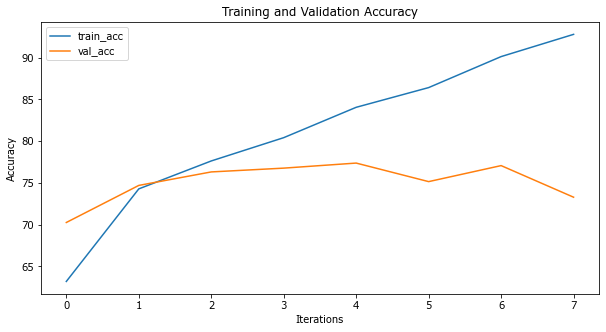

In [8]:
from utils.visualizer import visualize_accuracy, visualize_loss

visualize_accuracy(vgg8_bn_train_logs['accuracy'], vgg8_bn_val_logs['accuracy'])

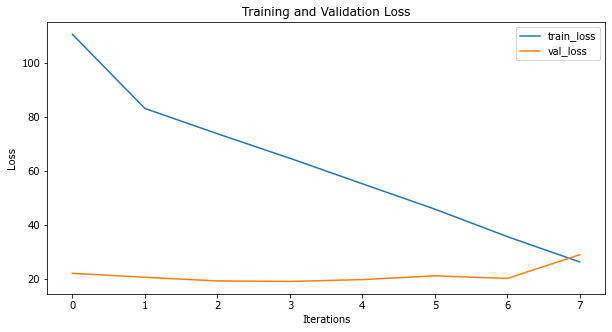

In [9]:
visualize_loss(vgg8_bn_train_logs['loss'], vgg8_bn_val_logs['loss'])

# Supervised Model (ResNet10)

In [10]:
from utils.MyDataset import MyDataset

train_imgs, val_imgs = train_test_split(main, test_size=0.2)

train_dataset = MyDataset(train_imgs, 'cellType')
val_dataset = MyDataset(val_imgs, 'cellType')
test_dataset = MyDataset(extra, '')

train_loader = DataLoader(
    dataset = train_dataset,
    num_workers = NUM_WORKERS,
    batch_size = TRAIN_BATCH_SIZE,
    shuffle = True
)

val_loader = DataLoader(
    dataset = val_dataset,
    num_workers = NUM_WORKERS,
    batch_size = VAL_BATCH_SIZE,
    shuffle = True
)

test_loader = DataLoader(
    dataset = test_dataset,
    num_workers = NUM_WORKERS,
    batch_size = 1,
    shuffle = True
)


In [11]:
from utils.trainer import train, val
from models.ResNet import resnet10

resnet10 = resnet10(num_classes=NUM_CLASSES, num_channels=IN_CHANNELS)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet10.parameters(), lr=LEARNING_RATE)

# Logs - Helpful for plotting after training finishes
resnet10_train_logs = {'loss' : [], 'accuracy' : [], 'epoch' : []}
resnet10_val_logs = {'loss' : [], 'accuracy' : [], 'epoch' : []}
resnet10_best_val_acc = 0.0
prev_resnet10_best_val_acc = 0.0
EARLY_STOPPING = 3

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}:")
    train_loss, train_acc = train(resnet10, train_loader, optimizer, loss_fn, NUM_CLASSES)
    resnet10_train_logs['loss'].append(train_loss)
    resnet10_train_logs['accuracy'].append(train_acc)
    resnet10_train_logs['epoch'].append(epoch)
    
    prev_resnet10_best_val_acc = resnet10_best_val_acc
    val_loss, val_acc, resnet10_best_val_acc = val(resnet10, val_loader, loss_fn, NUM_CLASSES, resnet10_best_val_acc, 'resnet10_supervised_test2')
    resnet10_val_logs['loss'].append(val_loss)
    resnet10_val_logs['accuracy'].append(val_acc)
    resnet10_val_logs['epoch'].append(epoch)
    
    # Check if best validation accuracy unchange in EARLY_STOPPING times, it will stop training
    if prev_resnet10_best_val_acc == resnet10_best_val_acc:
        unchange_val_acc_count += 1
    else:
        unchange_val_acc_count = 0
        
    if unchange_val_acc_count == EARLY_STOPPING:
        break

Epoch 1:


Val: 100%|██████████| 31/31 [00:09<00:00,  3.21batch/s, loss: 0.647088, accuracy: 73.282829% [1451/1980]]


New best validation accuracy: 73.282829, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/resnet10_supervised_test2_best.pth
Epoch 2:


Val: 100%|██████████| 31/31 [00:11<00:00,  2.65batch/s, loss: 0.818896, accuracy: 71.363640% [1413/1980]]


Epoch 3:


Val: 100%|██████████| 31/31 [00:18<00:00,  1.69batch/s, loss: 0.802500, accuracy: 69.898987% [1384/1980]]


Epoch 4:


Val: 100%|██████████| 31/31 [00:15<00:00,  2.03batch/s, loss: 0.792403, accuracy: 73.737373% [1460/1980]]


New best validation accuracy: 73.737373, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/resnet10_supervised_test2_best.pth
Epoch 5:


Val: 100%|██████████| 31/31 [00:14<00:00,  2.07batch/s, loss: 1.181960, accuracy: 65.656563% [1300/1980]]


Epoch 6:


Val: 100%|██████████| 31/31 [00:11<00:00,  2.63batch/s, loss: 0.756805, accuracy: 74.090912% [1467/1980]]


New best validation accuracy: 74.090912, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/resnet10_supervised_test2_best.pth
Epoch 7:


Val: 100%|██████████| 31/31 [00:12<00:00,  2.46batch/s, loss: 0.640425, accuracy: 68.989899% [1366/1980]]


Epoch 8:


Val: 100%|██████████| 31/31 [00:12<00:00,  2.41batch/s, loss: 0.518628, accuracy: 73.989899% [1465/1980]]


Epoch 9:


Val: 100%|██████████| 31/31 [00:14<00:00,  2.16batch/s, loss: 1.270135, accuracy: 74.848488% [1482/1980]]


New best validation accuracy: 74.848488, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/resnet10_supervised_test2_best.pth
Epoch 10:


Val: 100%|██████████| 31/31 [00:13<00:00,  2.38batch/s, loss: 0.870053, accuracy: 74.898987% [1483/1980]]

New best validation accuracy: 74.898987, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/resnet10_supervised_test2_best.pth


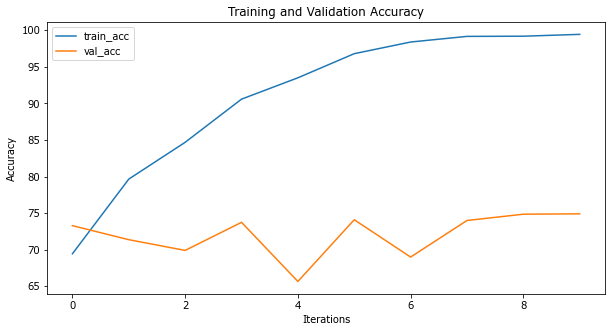

In [12]:
from utils.visualizer import visualize_accuracy, visualize_loss

visualize_accuracy(resnet10_train_logs['accuracy'], resnet10_val_logs['accuracy'])

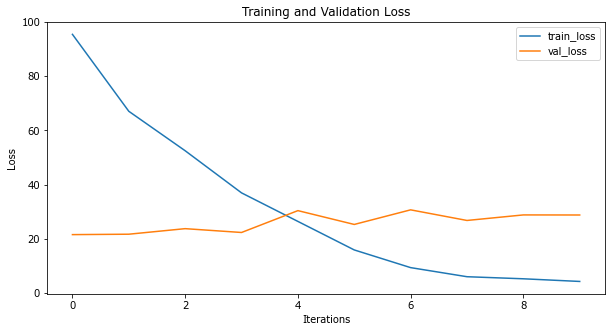

In [13]:
visualize_loss(resnet10_train_logs['loss'], resnet10_val_logs['loss'])

# Pseudo-Labeling 

In [14]:
LEARNING_RATE = 1e-4
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64
NUM_WORKERS = 4
EPOCHS = 10
NUM_CLASSES = len(main['cellType'].unique())
IN_CHANNELS = 3
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
EARLY_STOPPING = 3

In [24]:
from utils.trainer import test
from models.ResNet import resnet10
from models.VGG import vgg8_bn

loss_fn = nn.CrossEntropyLoss()

filepath = os.getcwd() + '/model_saved/'
model_name = filepath
model = None
saved = None
best_val_acc = 0


if resnet10_best_val_acc > vgg8_bn_best_val_acc:
    model_name += 'resnet10_supervised_test2_best.pth'
    model = resnet10(num_classes=NUM_CLASSES, num_channels=IN_CHANNELS)
    model.load_state_dict(torch.load(model_name)['model_state_dict'])
    best_val_acc = torch.load(model_name)['best_val_acc']
else:
    model_name += 'vgg8_bn_supervised_test2_best.pth'
    model = vgg8_bn(num_classes=NUM_CLASSES, in_channels=IN_CHANNELS)  
    model.load_state_dict(torch.load(model_name)['model_state_dict'])
    best_val_acc = torch.load(model_name)['best_val_acc']


print(f'Choosing model: {model_name}')
y_pred = test(model, test_loader, loss_fn, NUM_CLASSES)
extra['cellType'] = y_pred
extra



Choosing model: d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/vgg8_bn_supervised_test2_best.pth


Test: 100%|██████████| 10384/10384 [02:29<00:00, 69.28batch/s]


,InstanceID,patientID,ImageName,isCancerous,cellType
0,12681,61,12681.png,0,2
1,12682,61,12682.png,0,1
2,12683,61,12683.png,0,2
3,12684,61,12684.png,0,0
4,12685,61,12685.png,0,0
...,...,...,...,...,...
10379,20028,99,20028.png,0,0
10380,20029,99,20029.png,0,1
10381,20030,99,20030.png,0,1
10382,20031,99,20031.png,0,0


> Merged mainData with extraData (pseudo label) and feed to model again to learn

In [25]:
data_merged = pd.concat([main, extra], axis=0)
data_merged

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
...,...,...,...,...,...,...
10379,20028,99,20028.png,NaN,0,0
10380,20029,99,20029.png,NaN,1,0
10381,20030,99,20030.png,NaN,1,0
10382,20031,99,20031.png,NaN,0,0


In [26]:
SEED = 6666
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## ResNet18

In [27]:
from utils.MyDataset import MyDataset

train_imgs, val_imgs = train_test_split(data_merged, test_size=0.3)

train_dataset = MyDataset(train_imgs, 'cellType')
val_dataset = MyDataset(val_imgs, 'cellType')

train_loader = DataLoader(
    dataset = train_dataset,
    num_workers = NUM_WORKERS,
    batch_size = TRAIN_BATCH_SIZE * 2,
    shuffle = True
)

val_loader = DataLoader(
    dataset = val_dataset,
    num_workers = NUM_WORKERS,
    batch_size = VAL_BATCH_SIZE * 2,
    shuffle = True
)

In [28]:
from utils.trainer import train, val
from models.ResNet import resnet18

resnet18_pseudo_label = resnet18(num_classes=NUM_CLASSES, num_channels=IN_CHANNELS)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18_pseudo_label.parameters(), lr=0.01)

# Logs - Helpful for plotting after training finishes
resnet18_pseudo_label_train_logs = {'loss' : [], 'accuracy' : [], 'epoch' : []}
resnet18_pseudo_label_val_logs = {'loss' : [], 'accuracy' : [], 'epoch' : []}
resnet18_pseudo_label_best_val_acc = 0.0
prev_resnet18_pseudo_label_best_val_acc = 0.0
unchange_val_acc_count = 0

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}:")
    train_loss, train_acc = train(resnet18_pseudo_label, train_loader, optimizer, loss_fn, NUM_CLASSES)
    resnet18_pseudo_label_train_logs['loss'].append(train_loss)
    resnet18_pseudo_label_train_logs['accuracy'].append(train_acc)
    resnet18_pseudo_label_train_logs['epoch'].append(epoch)
    
    prev_resnet18_pseudo_label_best_val_acc = resnet18_pseudo_label_best_val_acc
    val_loss, val_acc, resnet18_pseudo_label_best_val_acc = val(resnet18_pseudo_label, val_loader, loss_fn, NUM_CLASSES, resnet18_pseudo_label_best_val_acc, 'resnet18_pseudo_label_test2')
    resnet18_pseudo_label_val_logs['loss'].append(val_loss)
    resnet18_pseudo_label_val_logs['accuracy'].append(val_acc)
    resnet18_pseudo_label_val_logs['epoch'].append(epoch)
    
    # Check if best validation accuracy unchange in EARLY_STOPPING times, it will stop training
    if prev_resnet18_pseudo_label_best_val_acc == resnet18_pseudo_label_best_val_acc:
        unchange_val_acc_count += 1
    else:
        unchange_val_acc_count = 0
        
    if unchange_val_acc_count == EARLY_STOPPING:
        break

Epoch 1:


Val: 100%|██████████| 48/48 [00:26<00:00,  1.83batch/s, loss: 1.999709, accuracy: 43.014465% [2617/6084]]


New best validation accuracy: 43.014465, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/resnet18_pseudo_label_test2_best.pth
Epoch 2:


Val: 100%|██████████| 48/48 [00:29<00:00,  1.65batch/s, loss: 1.191372, accuracy: 53.418804% [3250/6084]]


New best validation accuracy: 53.418804, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/resnet18_pseudo_label_test2_best.pth
Epoch 3:


Val: 100%|██████████| 48/48 [00:27<00:00,  1.76batch/s, loss: 1.154409, accuracy: 53.040764% [3227/6084]]


Epoch 4:


Val: 100%|██████████| 48/48 [00:24<00:00,  2.00batch/s, loss: 1.279753, accuracy: 53.829716% [3275/6084]]


New best validation accuracy: 53.829716, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/resnet18_pseudo_label_test2_best.pth
Epoch 5:


Val: 100%|██████████| 48/48 [00:27<00:00,  1.74batch/s, loss: 1.131180, accuracy: 46.137409% [2807/6084]]


Epoch 6:


Val: 100%|██████████| 48/48 [00:23<00:00,  2.02batch/s, loss: 0.978378, accuracy: 55.259697% [3362/6084]]


New best validation accuracy: 55.259697, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/resnet18_pseudo_label_test2_best.pth
Epoch 7:


Val: 100%|██████████| 48/48 [00:25<00:00,  1.86batch/s, loss: 1.248541, accuracy: 49.441158% [3008/6084]]


Epoch 8:


Val: 100%|██████████| 48/48 [00:28<00:00,  1.70batch/s, loss: 1.291133, accuracy: 48.964497% [2979/6084]]


Epoch 9:


Val: 100%|██████████| 48/48 [00:26<00:00,  1.84batch/s, loss: 1.052993, accuracy: 55.999344% [3407/6084]]


New best validation accuracy: 55.999344, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/resnet18_pseudo_label_test2_best.pth
Epoch 10:


Val: 100%|██████████| 48/48 [00:18<00:00,  2.54batch/s, loss: 1.239078, accuracy: 52.366863% [3186/6084]]


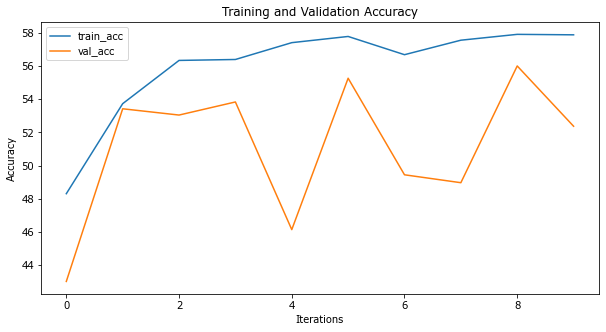

In [29]:
from utils.visualizer import visualize_accuracy, visualize_loss

visualize_accuracy(resnet18_pseudo_label_train_logs['accuracy'], resnet18_pseudo_label_val_logs['accuracy'])

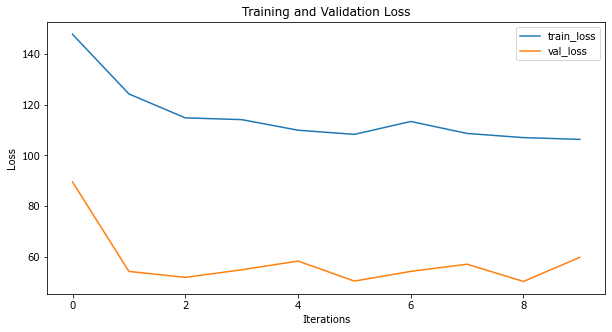

In [30]:
visualize_loss(resnet18_pseudo_label_train_logs['loss'], resnet18_pseudo_label_val_logs['loss'])

## VGG16

In [31]:
from utils.MyDataset import MyDataset

train_imgs, val_imgs = train_test_split(data_merged, test_size=0.3)

train_dataset = MyDataset(train_imgs, 'cellType')
val_dataset = MyDataset(val_imgs, 'cellType')

train_loader = DataLoader(
    dataset = train_dataset,
    num_workers = NUM_WORKERS,
    batch_size = TRAIN_BATCH_SIZE * 2,
    shuffle = True
)

val_loader = DataLoader(
    dataset = val_dataset,
    num_workers = NUM_WORKERS,
    batch_size = VAL_BATCH_SIZE * 2,
    shuffle = True
)

In [32]:
from utils.trainer import train, val
from models.VGG import vgg16_bn

vgg16_bn_pseudo_label = vgg16_bn(num_classes=NUM_CLASSES, in_channels=IN_CHANNELS)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16_bn_pseudo_label.parameters(), lr=0.01)

# Logs - Helpful for plotting after training finishes
vgg16_bn_pseudo_label_train_logs = {'loss' : [], 'accuracy' : [], 'epoch' : []}
vgg16_bn_pseudo_label_val_logs = {'loss' : [], 'accuracy' : [], 'epoch' : []}
vgg16_bn_pseudo_label_best_val_acc = 0.0
prev_vgg16_bn_pseudo_label_best_val_acc = 0.0
unchange_val_acc_count = 0

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}:")
    train_loss, train_acc = train(vgg16_bn_pseudo_label, train_loader, optimizer, loss_fn, NUM_CLASSES)
    vgg16_bn_pseudo_label_train_logs['loss'].append(train_loss)
    vgg16_bn_pseudo_label_train_logs['accuracy'].append(train_acc)
    vgg16_bn_pseudo_label_train_logs['epoch'].append(epoch)
    
    prev_vgg16_bn_pseudo_label_best_val_acc = vgg16_bn_pseudo_label_best_val_acc
    val_loss, val_acc, vgg16_bn_pseudo_label_best_val_acc = val(vgg16_bn_pseudo_label, val_loader, loss_fn, NUM_CLASSES, vgg16_bn_pseudo_label_best_val_acc, 'vgg16_bn_pseudo_label_test2')
    vgg16_bn_pseudo_label_val_logs['loss'].append(val_loss)
    vgg16_bn_pseudo_label_val_logs['accuracy'].append(val_acc)
    vgg16_bn_pseudo_label_val_logs['epoch'].append(epoch)
    
    # Check if best validation accuracy unchange in EARLY_STOPPING times, it will stop training
    if prev_vgg16_bn_pseudo_label_best_val_acc == vgg16_bn_pseudo_label_best_val_acc:
        unchange_val_acc_count += 1
    else:
        unchange_val_acc_count = 0
        
    if unchange_val_acc_count == EARLY_STOPPING:
        break

Epoch 1:


Val: 100%|██████████| 48/48 [00:44<00:00,  1.07batch/s, loss: 1.319339, accuracy: 43.195267% [2628/6084]]


New best validation accuracy: 43.195267, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/vgg16_bn_pseudo_label_test2_best.pth
Epoch 2:


Val: 100%|██████████| 48/48 [00:47<00:00,  1.00batch/s, loss: 1.153623, accuracy: 43.195267% [2628/6084]]


Epoch 3:


Val: 100%|██████████| 48/48 [00:42<00:00,  1.12batch/s, loss: 1.661462, accuracy: 21.038790% [1280/6084]]


Epoch 4:


Val: 100%|██████████| 48/48 [00:47<00:00,  1.00batch/s, loss: 1.230480, accuracy: 48.553585% [2954/6084]]


New best validation accuracy: 48.553585, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/vgg16_bn_pseudo_label_test2_best.pth
Epoch 5:


Val: 100%|██████████| 48/48 [00:44<00:00,  1.08batch/s, loss: 1.082227, accuracy: 51.890205% [3157/6084]]


New best validation accuracy: 51.890205, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/vgg16_bn_pseudo_label_test2_best.pth
Epoch 6:


Val: 100%|██████████| 48/48 [00:43<00:00,  1.11batch/s, loss: 1.008756, accuracy: 50.378040% [3065/6084]]


Epoch 7:


Val: 100%|██████████| 48/48 [00:38<00:00,  1.25batch/s, loss: 1.249695, accuracy: 39.414860% [2398/6084]]


Epoch 8:


Val: 100%|██████████| 48/48 [00:41<00:00,  1.16batch/s, loss: 1.096993, accuracy: 49.293228% [2999/6084]]


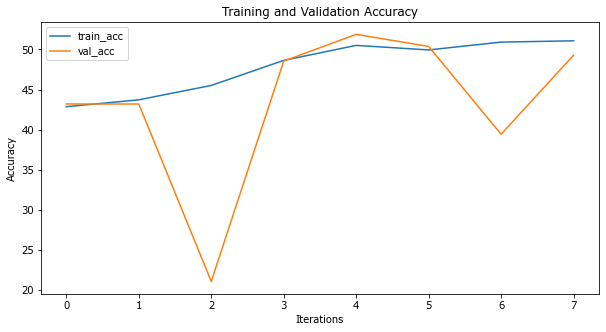

In [33]:
from utils.visualizer import visualize_accuracy, visualize_loss

visualize_accuracy(vgg16_bn_pseudo_label_train_logs['accuracy'], vgg16_bn_pseudo_label_val_logs['accuracy'])

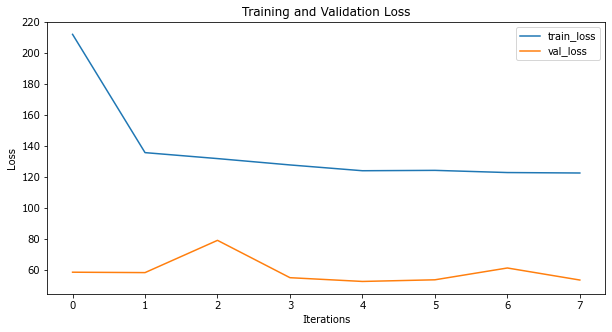

In [34]:
visualize_loss(vgg16_bn_pseudo_label_train_logs['loss'], vgg16_bn_pseudo_label_val_logs['loss'])